In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


**CÀI ĐẶT**

In [2]:
# Cài đặt
np.random.seed(42)
tfd = tfp.distributions
sts = tfp.sts

**ĐỌC DỮ LIỆU**

In [3]:
# Load dữ liệu
df = pd.read_csv('VIX_Cleaned.csv', parse_dates=['Date'], index_col='Date')
y_full = df['Close'].values.astype(np.float32)
dates_full = df.index

**CHIA TỈ LỆ DỮ LIỆU**

In [4]:
# Hàm chia tỷ lệ train/val/test
def split_data(y, ratios):
    n = len(y)
    n_train = int(ratios[0] * n)
    n_val = int(ratios[1] * n)
    n_test = n - n_train - n_val
    return (y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:],
            dates_full[:n_train], dates_full[n_train:n_train+n_val], dates_full[n_train+n_val:])

**HUẤN LUYỆN MÔ HÌNH BSTS**

In [5]:
# Huấn luyện BSTS
def fit_bsts(series, num_steps=300):
    level = sts.LocalLinearTrend(observed_time_series=series)
    model = sts.Sum([level], name='bsts')
    surrogate = sts.build_factored_surrogate_posterior(model)
    optimizer = tf.optimizers.Adam(learning_rate=0.1)

    @tf.function(experimental_compile=True)
    def run_vi():
        return tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model.joint_log_prob(series),
            surrogate_posterior=surrogate,
            optimizer=optimizer,
            num_steps=num_steps)

    _ = run_vi()
    samples = surrogate.sample(50)
    return model, samples

def forecast_and_evaluate(model, samples, observed, actual, steps):
    fc = sts.forecast(model, observed_time_series=observed, parameter_samples=samples, num_steps_forecast=steps)
    mean, std = fc.mean().numpy().squeeze(), fc.stddev().numpy().squeeze()
    actual = np.asarray(actual)
    mae = mean_absolute_error(actual, mean)
    mse = mean_squared_error(actual, mean)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - mean) / actual[actual != 0])) * 100 if np.any(actual != 0) else np.nan
    r2 = r2_score(actual, mean)
    return mean, std, {'mae': mae, 'mse': mse, 'rmse': rmse, 'mape': mape, 'r2': r2}

**BIỂU ĐỒ KẾT QUẢ**

In [6]:
# Vẽ kết quả
def plot_model_result(dates, train, val, test, mean_val, std_val, mean_test, std_test, label_suffix=''):
    plt.figure(figsize=(14, 7))
    plt.plot(dates[:len(train)], train, color='black', label='Train')
    plt.plot(dates[len(train):len(train)+len(val)], val, color='blue', label='Validation')
    plt.plot(dates[len(train)+len(val):], test, color='purple', label='Test')

    dates_val = dates[len(train):len(train)+len(val)]
    dates_test = dates[len(train)+len(val):]

    plt.plot(dates_val, mean_val, '--', color='orange', label='Forecast Val')
    plt.fill_between(dates_val, mean_val - 1.96*std_val, mean_val + 1.96*std_val, color='orange', alpha=0.2)

    plt.plot(dates_test, mean_test, '--', color='green', label='Forecast Test')
    plt.fill_between(dates_test, mean_test - 1.96*std_test, mean_test + 1.96*std_test, color='green', alpha=0.2)

    plt.title(f'BSTS Training Results: Train / Validation / Test with Forecasts {label_suffix}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**CHẠY VỚI 3 TỈ LỆ**

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`



==== Ratio (0.75, 0.1, 0.15) ====
Test MAE: 2252.89, MAPE: 19.16%, MSE: 9346081.00, RMSE: 3057.14, R-SQUARE: -7.15


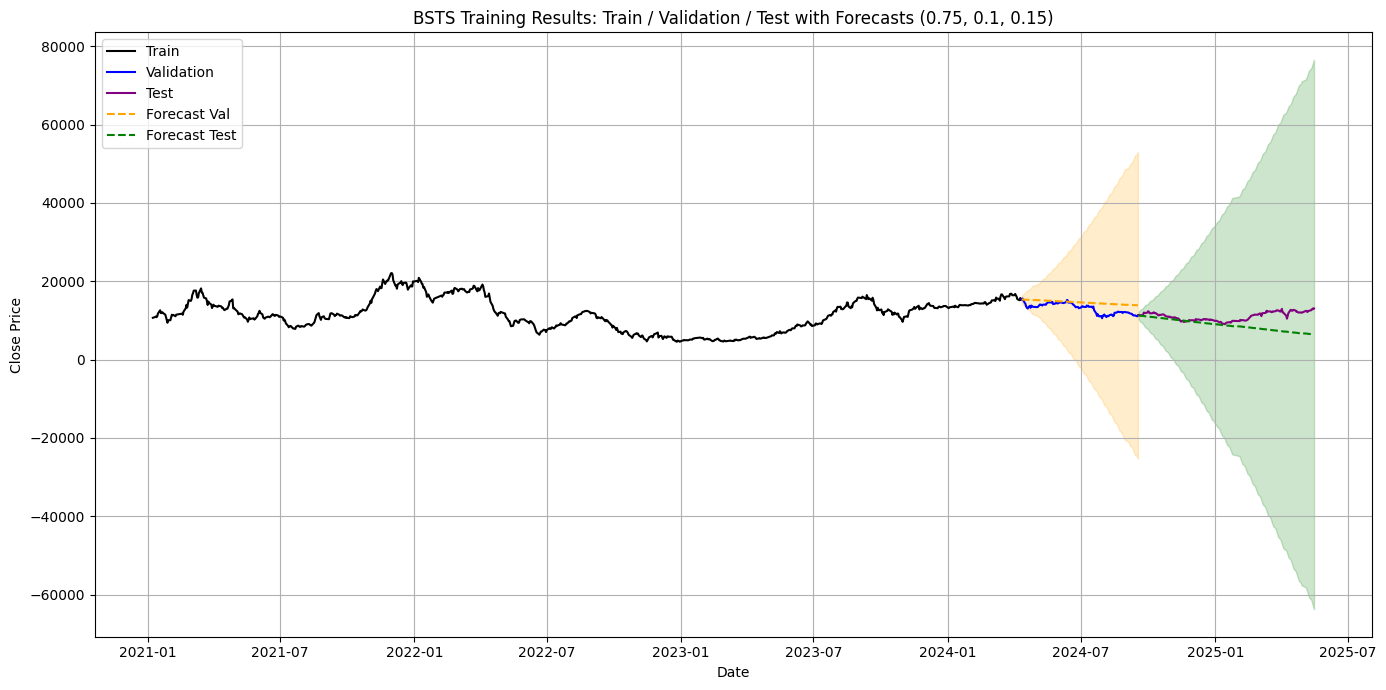


==== Ratio (0.7, 0.1, 0.2) ====
Test MAE: 3906.74, MAPE: 34.18%, MSE: 25592042.00, RMSE: 5058.86, R-SQUARE: -19.39


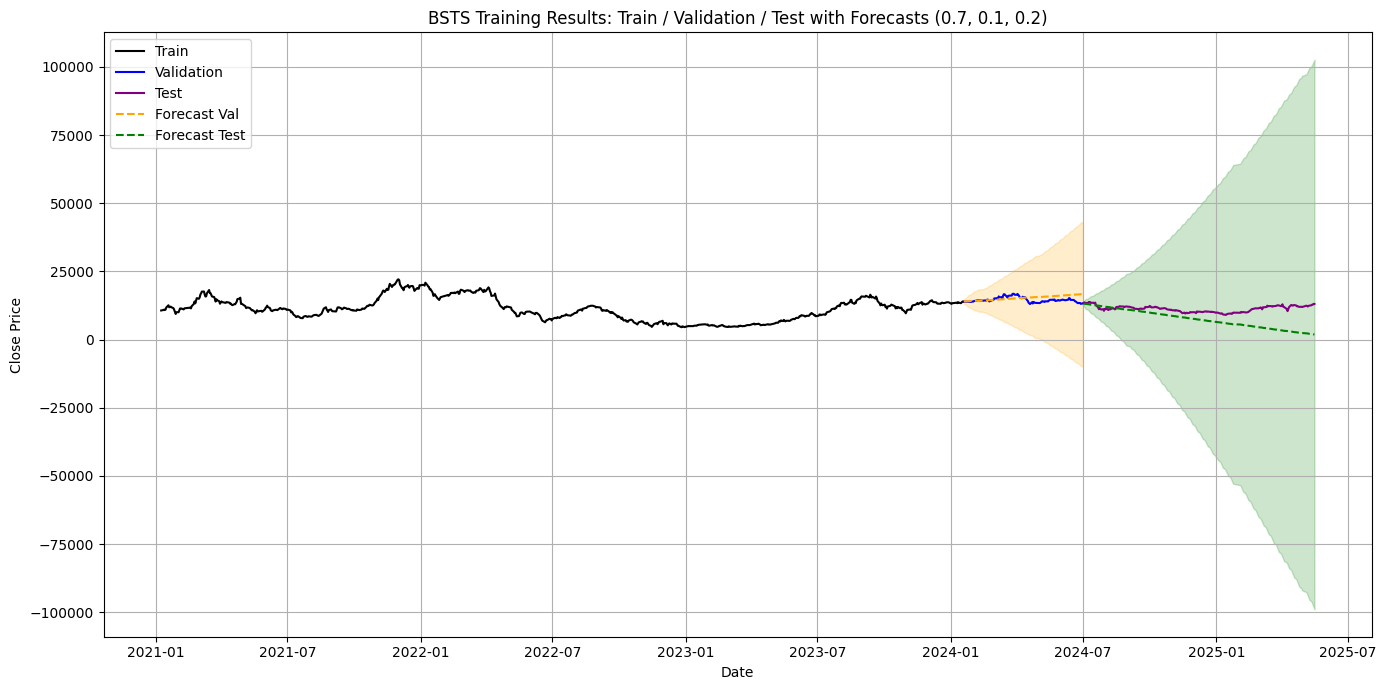


==== Ratio (0.65, 0.1, 0.25) ====
Test MAE: 4967.82, MAPE: 44.68%, MSE: 29260142.00, RMSE: 5409.26, R-SQUARE: -11.28


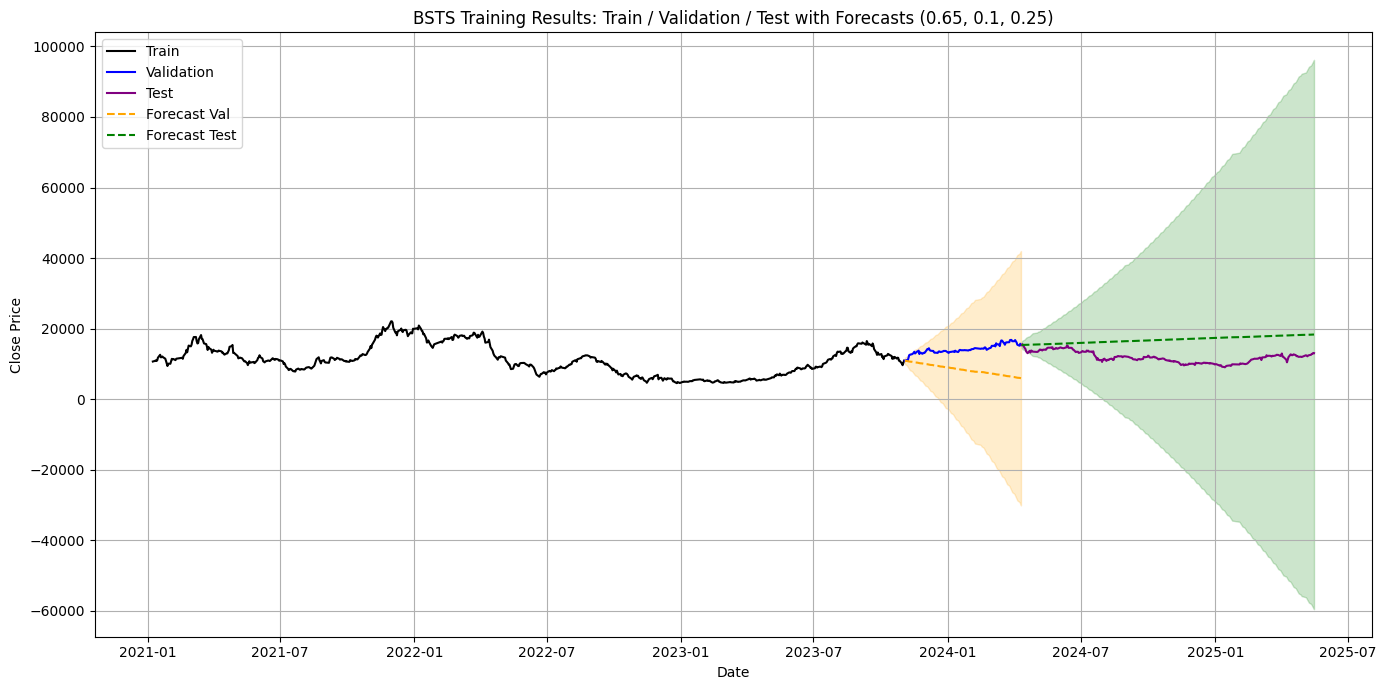

In [7]:
# Chạy với 3 tỷ lệ
ratios_list = [(0.75, 0.1, 0.15), (0.7, 0.1, 0.2), (0.65, 0.10, 0.25)]
best_model_info = {'score': -np.inf}

for ratios in ratios_list:
    # Chia
    train, val, test, d_train, d_val, d_test = split_data(y_full, ratios)
    dates = np.concatenate([d_train, d_val, d_test])

    # Train + forecast val
    model_train, q_train = fit_bsts(train)
    mean_val, std_val, val_metrics = forecast_and_evaluate(model_train, q_train, train, val, len(val))

    # Train+val + forecast test
    train_val = np.concatenate([train, val])
    model_tv, q_tv = fit_bsts(train_val)
    mean_test, std_test, test_metrics = forecast_and_evaluate(model_tv, q_tv, train_val, test, len(test))

    print(f"\n==== Ratio {ratios} ====")
    print(f"Test MAE: {test_metrics['mae']:.2f}, MAPE: {test_metrics['mape']:.2f}%, MSE: {test_metrics['mse']:.2f}, RMSE: {test_metrics['rmse']:.2f}, R-SQUARE: {test_metrics['r2']:.2f}")

    r2 = test_metrics['r2']
    if r2 > best_model_info['score']:
        best_model_info = {
            'score': r2,
            'train_val': np.concatenate([train, val]),
            'ratios': ratios,
            'test': test,
            'dates': dates,
            'mean_val': mean_val,
            'std_val': std_val,
            'mean_test': mean_test,
            'std_test': std_test,
            'train': train,
            'val': val
        }

    plot_model_result(dates, train, val, test, mean_val, std_val, mean_test, std_test, label_suffix=str(ratios))

**DỰ BÁO 30 NGÀY TIẾP THEO**


Best model based on test R²: -7.1496 @ ratios (0.75, 0.1, 0.15)


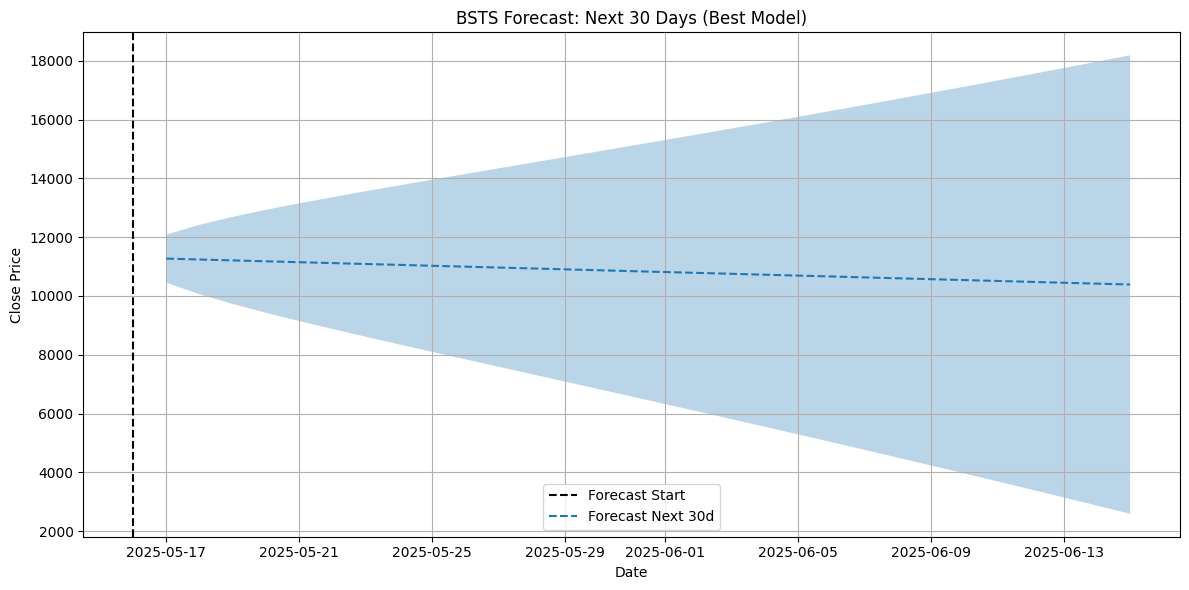

In [8]:
# Dự báo 30 ngày từ model tốt nhất
print(f"\nBest model based on test R²: {best_model_info['score']:.4f} @ ratios {best_model_info['ratios']}")
model_best, q_best = fit_bsts(best_model_info['train_val'])
fc_next = sts.forecast(model_best, observed_time_series=best_model_info['train_val'], parameter_samples=q_best, num_steps_forecast=30)
mean_next, std_next = fc_next.mean().numpy().squeeze(), fc_next.stddev().numpy().squeeze()
future_dates = pd.date_range(start=best_model_info['dates'][-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Plot forecast 30 ngày
plt.figure(figsize=(12, 6))
#plt.plot(df.index, y_full, label='Observed')
plt.axvline(df.index[-1], color='k', linestyle='--', label='Forecast Start')
plt.plot(future_dates, mean_next, '--', label='Forecast Next 30d')
plt.fill_between(future_dates, mean_next - 1.96*std_next, mean_next + 1.96*std_next, alpha=0.3)
plt.title('BSTS Forecast: Next 30 Days (Best Model)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

